In [6]:
# Parameters – this is the ONLY place you should edit
# when switching models / experiments / obs datasets.

### USER EDIT start

# ESM datastore (model output) – change this for a different run/model
esm_file = "/scratch/tm70/ek4684/access-om3/archive/MCW_100km_jra_iaf_IC4_KPP/experiment_datastore.json"

# What physical field you want, in CF terms (stays the same across models)
variable_standard_name = "Mean wave period (Tm0,2)"

# Fallback variable name to use if the catalog doesn’t expose standard_name
fallback_variable_names = ["T02"]


# Frequency depends on the datastore you’re using:
data_frequency = "1mon"

# Optional special-case switches (e.g. 25 km quirks)
APPLY_OBS_25KM_Y_SLICE = False

# Plot settings
dpi = 300

### USER EDIT stop

import os
import sys
from matplotlib import rcParams

# Change working directory to the notebooks folder in the repo
project_root = f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1"
notebooks_dir = os.path.join(project_root, "notebooks")

# This makes CWD match where SST.ipynb and exptdata_access.py live
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())

from exptdata_access import get_experiment_info, guess_experiment_from_esm_file
from model_agnostic import get_lon_lat_from_catalog, select_variable

%matplotlib inline
rcParams["figure.dpi"] = dpi

plotfolder = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

cache_file = "/g/data/tm70/ek4684/ezhil_notebooks/era5_mwp_mean_1958_2013.nc"

# Infer model information from the datastore path
expt_key, info = guess_experiment_from_esm_file(esm_file)

model_name = info["model"]             # OM3 or CM3
exptname = os.path.basename(os.path.dirname(esm_file))

print(f"Running notebook for model: {model_name}")
print("ESM datastore path:", esm_file)
print("Plot folder path:", plotfolder)

Changed working directory to: /g/data/tm70/ek4684/access-om3-paper-1/notebooks
Running notebook for model: ACCESS-OM3
ESM datastore path: /scratch/tm70/ek4684/access-om3/archive/MCW_100km_jra_iaf_IC4_KPP/experiment_datastore.json
Plot folder path: /g/data/tm70/ek4684/access-om3-paper-figs/


In [7]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
import numpy as np
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import LogNorm
from distributed import Client
import cftime
import os, glob
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
import cmocean.cm as cmo
from matplotlib.ticker import FormatStrFormatter
from cartopy.util import add_cyclic_point
from typing import Iterable, Optional, Sequence, Tuple, Union
import xesmf as xe


xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import string
import xesmf
import cmocean

In [8]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45937 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43485' processes=7 threads=7, memory=32.00 GiB>

In [9]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [11]:
if os.path.exists(cache_file):
    print(f"Loading cached ERA5 mean: {cache_file}")
    era_mean = xr.open_dataset(cache_file)["p140232"]

else:
    print("Cached file not found — computing ERA5 mean")
    base = "/g/data/rt52/era5/single-levels/reanalysis/mwp"
    years = range(1958, 2014)  # inclusive of 1968
    files = []
    for y in years:
        files += sorted(glob.glob(f"{base}/{y}/mwp_era5_wave_sfc_{y}*.nc"))
    print("nfiles:", len(files))
    print("first:", files[0])
    print("last :", files[-1])
                
    ds_era = xr.open_mfdataset(
            files,
            combine="by_coords",
            parallel=True,
            chunks={"time": 744},   # one month (or use chunks="auto")
        )["mwp"]
        
    # optional: reduce memory bandwidth
    ds_era = ds_era.astype("float32")
        
    era_mean = ds_era.mean("time").compute()
    print("era_mean dims:", era_mean.dims)
    
    # Save to disk (this triggers computation)   
    era_mean.to_dataset(name="mwp").to_netcdf(cache_file,
            encoding={
            "mwp": {
                "zlib": True,
                "complevel": 4,
                "dtype": "float32",
                "_FillValue": -1.0e20,}})
    print(f"Saved ERA5 mean to {cache_file}")

Cached file not found — computing ERA5 mean
nfiles: 672
first: /g/data/rt52/era5/single-levels/reanalysis/mwp/1958/mwp_era5_wave_sfc_19580101-19580131.nc
last : /g/data/rt52/era5/single-levels/reanalysis/mwp/2013/mwp_era5_wave_sfc_20131201-20131231.nc
era_mean dims: ('latitude', 'longitude')
Saved ERA5 mean to /g/data/tm70/ek4684/ezhil_notebooks/era5_mwp_mean_1958_2013.nc


In [12]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [13]:
def _align_lonlat_dims(da_model, lon, lat):
    # propose mapping from common grid dims -> model dims
    proposed = {
        "lonh": "nx", "xh": "nx", "x": "nx", "xt_ocean": "nx",
        "lath": "ny", "yh": "ny", "y": "ny", "yt_ocean": "ny",
    }

    def _rename_only_existing(da):
        # keep only keys that exist in this DataArray (dims or coords)
        mapping = {k: v for k, v in proposed.items() if (k in da.dims) or (k in da.coords)}
        return da.rename(mapping) if mapping else da

    lon = _rename_only_existing(lon)
    lat = _rename_only_existing(lat)

    # sanity checks (only for overlapping dims)
    for d in set(lon.dims).intersection(da_model.dims):
        if lon.sizes[d] != da_model.sizes[d]:
            raise ValueError(f"lon size mismatch on dim {d}: {lon.sizes[d]} vs {da_model.sizes[d]}")
    for d in set(lat.dims).intersection(da_model.dims):
        if lat.sizes[d] != da_model.sizes[d]:
            raise ValueError(f"lat size mismatch on dim {d}: {lat.sizes[d]} vs {da_model.sizes[d]}")

    return lon, lat

In [14]:

def time_percentiles(
    da: xr.DataArray,
    *,
    time_dim: str = "time",
    q_levels: Sequence[float] = (0.90, 0.99),
    mask: Optional[xr.DataArray] = None,
    skipna: bool = True,
    eps_min_count: int = 1,     # require at least this many valid samples along time
    compute: bool = False,      # keep lazy by default
    name: Optional[str] = None,
) -> xr.Dataset:
    """
    Compute percentile maps over time for a single dataset.

    Parameters
    ----------
    da : xr.DataArray
        Must include `time_dim` plus spatial dims (e.g., ny,nx or lat,lon).
    time_dim : str
        Name of the time dimension.
    q_levels : sequence of float
        Quantile levels in (0,1), e.g. (0.9, 0.99).
    mask : xr.DataArray, optional
        Boolean mask (True=keep). Can be static (ny,nx) or time-varying (time,ny,nx).
    skipna : bool
        Ignore NaNs along time when computing quantiles.
    eps_min_count : int
        Mask output where fewer than this many finite samples exist along time.
        Helps avoid garbage where obs is mostly missing (ice/land edges).
    compute : bool
        If True, compute immediately (useful before saving).
    name : str, optional
        Base name for output variables.

    Returns
    -------
    xr.Dataset
        Variables like q90_<name>, q99_<name> (maps on spatial dims).
    """
    if time_dim not in da.dims:
        raise ValueError(f"DataArray must have time dimension '{time_dim}'. Found dims={da.dims}")

    da_a = da
    varname = name or da_a.name or "var"

    # Apply mask if provided
    if mask is not None:
        mask_a, da_a = xr.align(mask, da_a, join="inner")
        da_a = da_a.where(mask_a.astype(bool))

    # Ensure we don't return percentiles where there's basically no data
    n_valid = da_a.notnull().sum(time_dim)
    out = xr.Dataset()

    for q in q_levels:
        if not (0.0 < q < 1.0):
            raise ValueError(f"Quantiles must be in (0,1). Got {q}")

        tag = f"q{int(round(q * 100)):02d}_{varname}"
        qmap = da_a.quantile(q, dim=time_dim, skipna=skipna)

        # Mask cells with too few valid samples
        qmap = qmap.where(n_valid >= eps_min_count)

        out[tag] = qmap

    out.attrs.update({
        "description": "Time-percentile maps for a single variable",
        "time_dim": time_dim,
        "q_levels": ",".join(str(x) for x in q_levels),
        "min_valid_count": int(eps_min_count),
        "variable": varname,
    })

    return out.compute() if compute else out

In [15]:
def plot(dat, title=None, projection=None, add_blue_marble=True, **kwargs):
    """
    Generic 2D map plot helper for model / obs / bias fields.

    - Works for any variable (SST, SSH, salinity, etc.).
    - Assumes the last two dimensions are (y, x) horizontal dims.
    - Uses contourf with a cartopy projection.
    """

    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    from textwrap import wrap

    # Make sure we're working with a DataArray
    da = dat
    if not isinstance(da, xr.DataArray):
        raise TypeError("plot() expects an xarray.DataArray")

    # Handle simple time dimension cases (e.g. time-mean or single time step)
    if da.ndim == 3 and "time" in da.dims and da.sizes["time"] == 1:
        da = da.isel(time=0, drop=True)

    if da.ndim != 2:
        raise ValueError(
            f"plot() expects a 2D field or a 3D field with singleton time; got dims {da.dims}"
        )

    # Infer horizontal dims as the last two dims
    ydim, xdim = da.dims[-2], da.dims[-1]

    # Title and colourbar label from attributes
    long_name = da.attrs.get("long_name", da.name or "Field")
    units = da.attrs.get("units", "")

    if title is None:
        title = long_name

    cbar_label = long_name if units == "" else f"{long_name} [{units}]"
    cbar_label = "\n".join(wrap(cbar_label, 45))

    # Projection: default to Robinson
    if projection is None:
        projection = ccrs.Robinson(central_longitude=-100)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=projection)

    # Main filled contour plot
    da.plot.contourf(
        ax=ax,
        x=xdim,
        y=ydim,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "label": cbar_label,
            "fraction": 0.03,
            "aspect": 15,
            "shrink": 0.7,
        },
        **kwargs,
    )

    # Optional blue marble overlay if available
    # if add_blue_marble and "blue_marble" in globals() and "blue_marble_extent" in globals():
    #    ax.imshow(
    #        blue_marble,
    #        extent=blue_marble_extent,
    #        transform=ccrs.PlateCarree(),
    #        origin="upper",
    #    )

    ax.coastlines()
    plt.title(title)
    plt.tight_layout()

In [16]:
def wrap_lon_360(da, lon_name="longitude"):
    lon = da[lon_name]
    lon2 = lon % 360
    return da.assign_coords({lon_name: lon2}).sortby(lon_name)

In [17]:
def wrap_lon_180(da, lon_name="longitude"):
    lon = da[lon_name]
    lon2 = ((lon + 180) % 360) - 180
    return da.assign_coords({lon_name: lon2}).sortby(lon_name)

In [18]:
exptname=os.path.basename(os.path.dirname(esm_file))
print("Experiment name:", exptname)

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

Experiment name: MCW_100km_jra_iaf_IC4_KPP


In [19]:
datastore_filtered = datastore.search(realm="wave")

available_variables(datastore_filtered)

variable_long_name variable_standard_name  \
variable                                                     
EF              1D spectral density                          
FP0                  Peak frequency                          
HS          Significant wave height                          
ICE                    Ice coverage                          
ICEF              Ice floe diameter                          
ICEH                  Ice thickness                          
T01        Mean wave period (Tm0,1)                          
T02        Mean wave period (Tm0,2)                          
T0M1      Mean wave period (Tm0,-1)                          
THM             Mean wave direction                          
UAX          Mean wind, x-component                          
UAY          Mean wind, y-component                          
USSX         Surface Stokes drift x                          
USSY         Surface Stokes drift y                          
mapsta                   map status                          

         variable_cell_methods variable_units  
variable                                       
EF                                       m2 s  
FP0                                       s-1  
HS                                          m  
ICE                                        nd  
ICEF                                        m  
ICEH                                        m  
T01                                         s  
T02                                         s  
T0M1                                        s  
THM                                       rad  
UAX                                     m s-1  
UAY                                     m s-1  
USSX                                    m s-1  
USSY                                    m s-1  
mapsta                               unitless

In [20]:
da_model = select_variable(
    datastore,
    variable_standard_name,
    fallback_variable_names,
    data_frequency=data_frequency,
)
print("Selected variable:", da_model.name)
print("dims:", da_model.dims)

CF-based lookup failed: ValueError('No entries found for this CF standard_name.')
No files matched frequency='1mon'; using any available frequency.
Selected variable via fallback name: T02
Selected variable: T02
dims: ('time', 'ny', 'nx')


In [21]:
# Discover lon/lat from the catalog (using the helper we wrote earlier)
lon, lat = get_lon_lat_from_catalog(datastore)
lon, lat = _align_lonlat_dims(da_model, lon, lat)
# Ensure model_all has CF longitude/latitude coords
try:
    # If CF coords already exist, just use them
    _ = da_model.cf["longitude"]
    _ = da_model.cf["latitude"]
    model_all = da_model
    print("Using existing CF longitude/latitude on da_model.")
except KeyError:
    # Otherwise, attach the lon/lat we discovered
    model_all = da_model.cf.assign_coords(
        {
            "longitude": lon,
            "latitude": lat,
        }
    )
    print("Attached longitude/latitude from catalog grid variables.")

print("model_all dims:", model_all.dims)

Attached longitude/latitude from catalog grid variables.
model_all dims: ('time', 'ny', 'nx')


In [22]:
averaging_mode = "last_n_years"   # or "full_period" / "fixed_period"
averaging_last_n_years = 1
averaging_start_date = "1958-01-02"
averaging_end_date   = None

In [23]:
# Put model time axis on a common calendar
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

# Inspect full time coverage
t0 = model_all.time.values[0]
t1 = model_all.time.values[-1]
print("Full model time range:", t0, "→", t1)

# Decide the averaging window based on configuration
if averaging_mode == "full_period":
    datestart = t0
    datestop = t1

elif averaging_mode == "last_n_years":
    datestop = t1
    # Subtract N years in a calendar-aware way
    datelist = list(cftime.to_tuple(datestop))
    datelist[0] -= averaging_last_n_years
    datestart = cftime.datetime(*datelist, calendar=datestop.calendar)

elif averaging_mode == "fixed_period":
    if averaging_start_date is None or averaging_end_date is None:
        raise ValueError(
            "averaging_mode='fixed_period' requires averaging_start_date and averaging_end_date"
        )
    # Use cftime to create start/end on the same calendar
    datestart = xr.cftime_range(
        start=averaging_start_date,
        periods=1,
        calendar="proleptic_gregorian",
    )[0]
    datestop = xr.cftime_range(
        start=averaging_end_date,
        periods=1,
        calendar="proleptic_gregorian",
    )[0]
else:
    raise ValueError(f"Unknown averaging_mode: {averaging_mode!r}")

timerange = slice(datestart, datestop)
print("Averaging window:", timerange)

# Restrict model to this configured window
model_window = model_all.cf.sel(time=timerange)
print("Windowed dims:", model_window.dims)

Full model time range: 1958-01-02 00:00:00 → 1974-05-30 00:00:00
Averaging window: slice(cftime.datetime(1973, 5, 30, 0, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True), cftime.DatetimeProlepticGregorian(1974, 5, 30, 0, 0, 0, 0, has_year_zero=True), None)
Windowed dims: ('time', 'ny', 'nx')


In [24]:
%%time
model = (
    model_window
    .cf.mean("time")          # CF-aware: whatever the time dim is called
    .pint.quantify()          # attach Pint units from attrs["units"]
    .pint.to("s")             # convert to m
    .pint.dequantify()        # back to plain DataArray for plotting / saving
)

print("Final model dims:", model.dims)
print("Final model units:", model.attrs.get("units"))

Final model dims: ('ny', 'nx')
Final model units: second
CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 29.2 ms


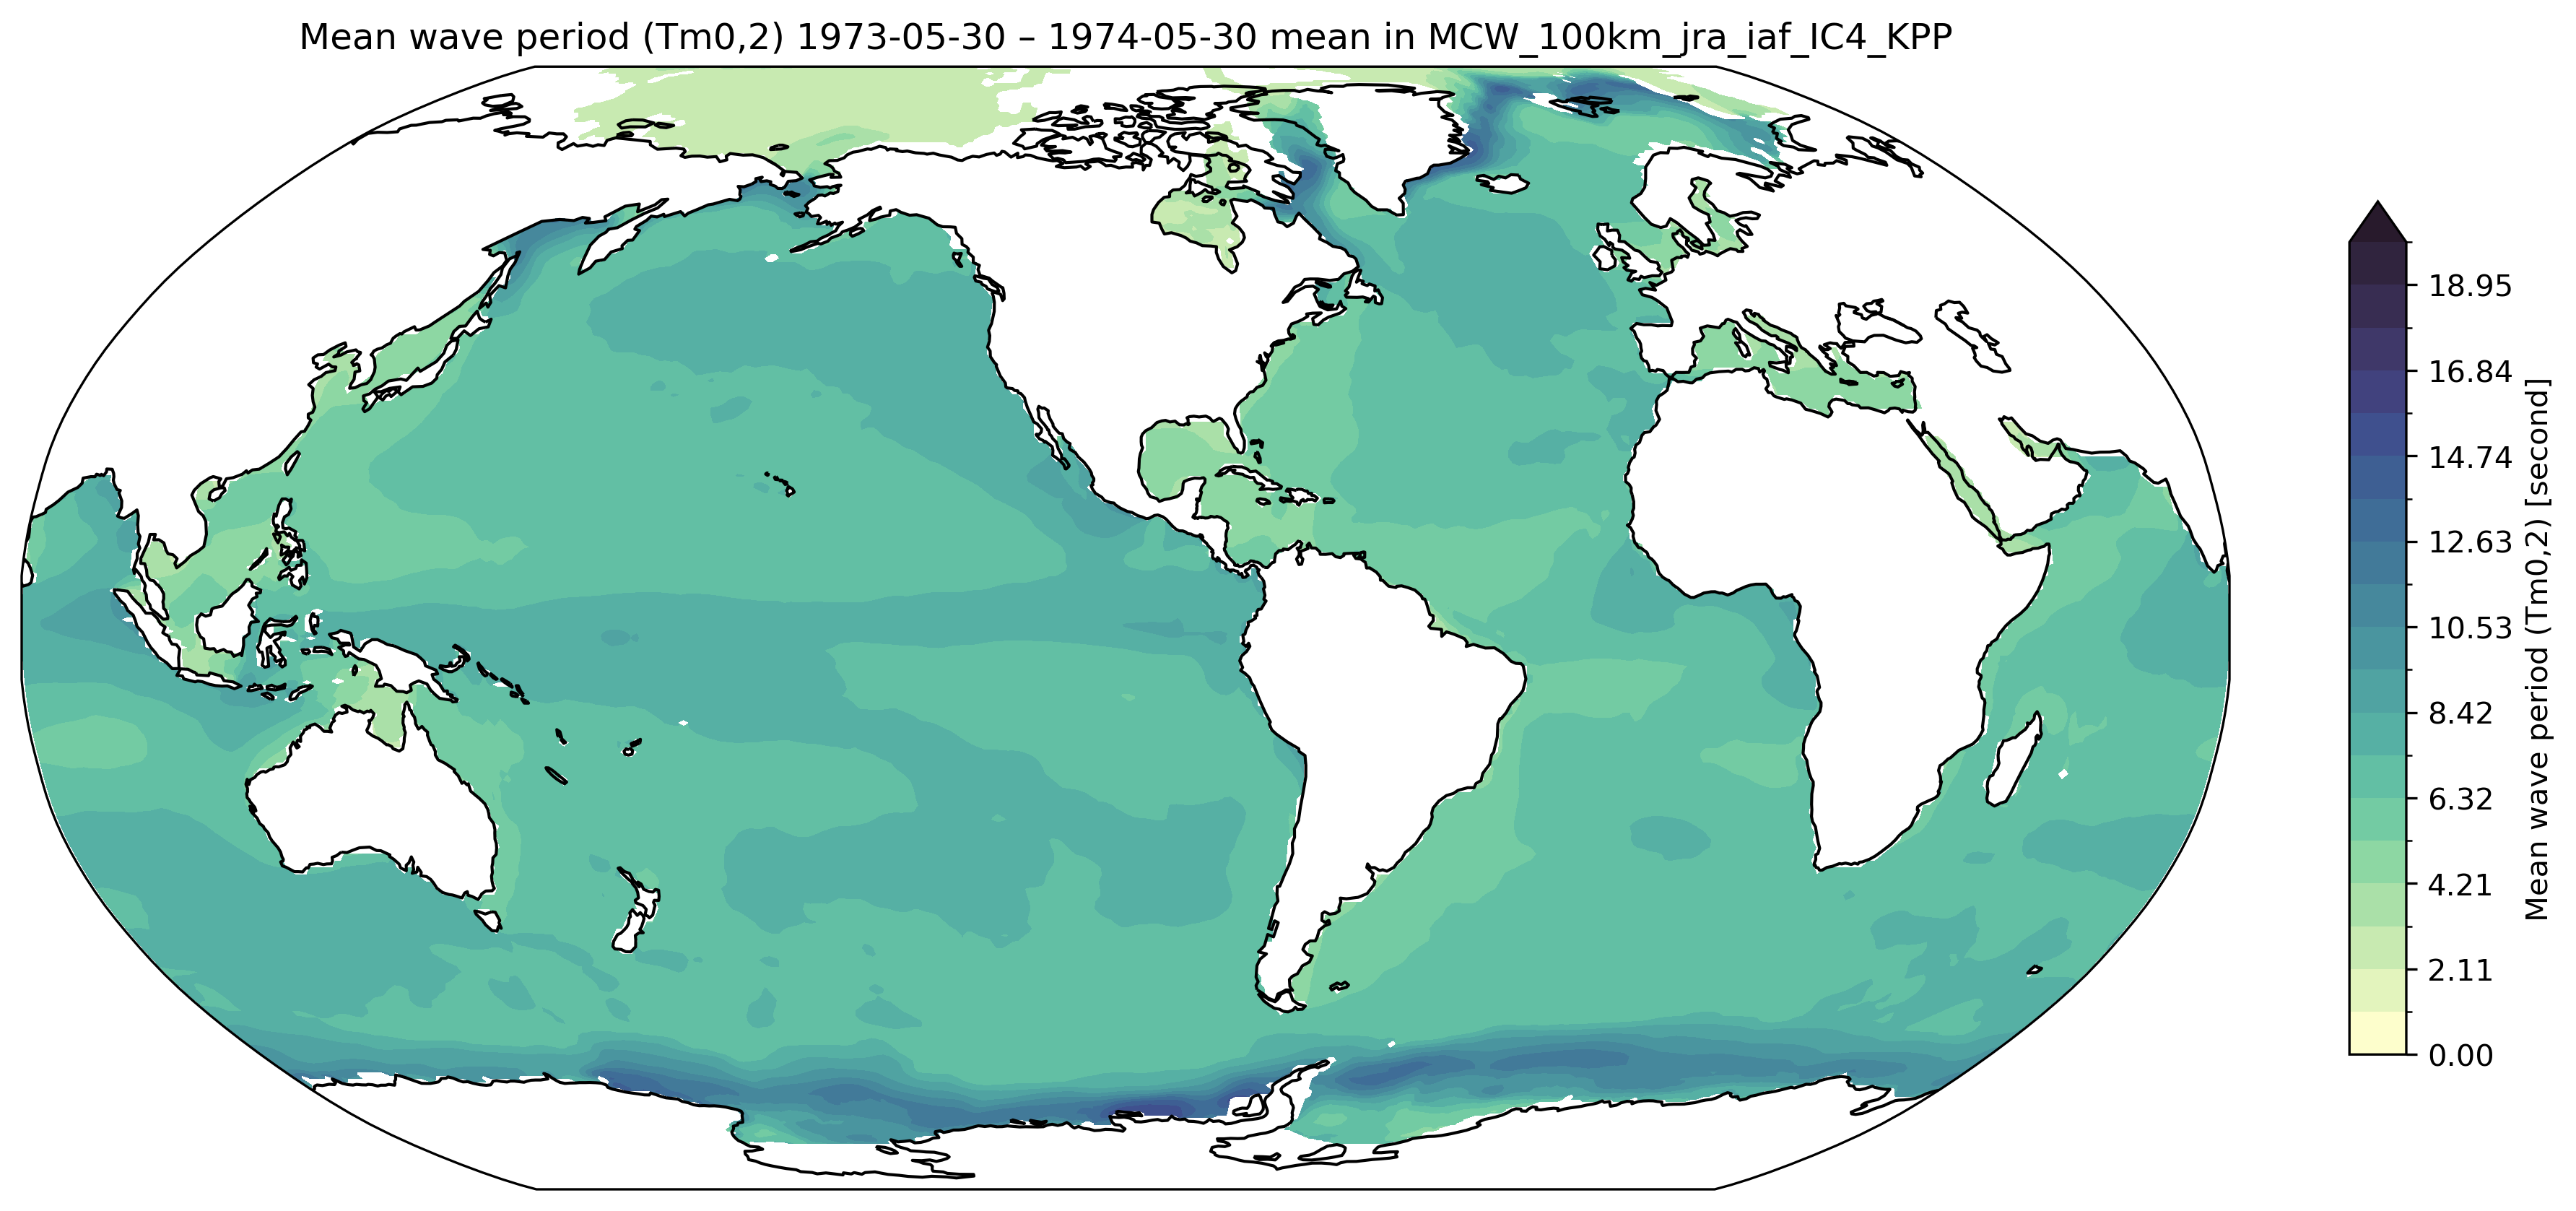

In [25]:
long_name = model.attrs.get("long_name", "Tm0,2")

ax = plot(
    model,
    levels=20,
    vmin=0,
    vmax=20,
    extend="max",
    cmap= cmocean.cm.deep,
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f"mean in {exptname}"
    ),
)

In [26]:
# strip any attrs that might make nx/ny look like lon/lat
if "nx" in model.coords:
    model["nx"].attrs = {}
if "ny" in model.coords:
    model["ny"].attrs = {}

# (optional) also ensure your real lon/lat have clear CF attrs
model["longitude"].attrs.update({"standard_name": "longitude", "units": "degrees_east"})
model["latitude"].attrs.update({"standard_name": "latitude", "units": "degrees_north"})

In [27]:
da_obs = era_mean
# 3) Make sure longitude / latitude coords are available in CF terms
try:
    _ = da_obs.cf["longitude"]
    _ = da_obs.cf["latitude"]
except KeyError:
    # If obs uses plain 'lon'/'lat' dims, expose them as CF coords
    rename_dict = {}
    if "lon" in da_obs.dims:
        rename_dict["lon"] = "longitude"
    if "lat" in da_obs.dims:
        rename_dict["lat"] = "latitude"
    if rename_dict:
        da_obs = da_obs.rename(rename_dict)

print("Obs dims:", da_obs.dims)
print("Obs coords:", list(da_obs.coords))

Obs dims: ('latitude', 'longitude')
Obs coords: ['longitude', 'latitude']


In [28]:
da_obs = era_mean  # dims: latitude, longitude

# 1) Make obs monotonic and in [-180, 180)
da_obs = da_obs.sortby("latitude")
obs_lon180 = ((da_obs["longitude"] + 180) % 360) - 180
da_obs = da_obs.assign_coords(longitude=obs_lon180).sortby("longitude")

# 2) Wrap MODEL target lon into [-180, 180) for interpolation
model_lon = model["longitude"]              # your -279.5..79.5
model_lon180 = ((model_lon + 180) % 360) - 180

# interp needs monotonic x; sort lon180 but keep index to restore
nx_sort = np.argsort(model_lon180.values)
model_lon180_sorted = model_lon180.isel(nx=nx_sort)

# latitude target (already monotonic, but keep as-is)
model_lat = model["latitude"]

# 3) Interpolate onto wrapped lon target
obs_on_model_sorted = da_obs.interp(
    longitude=model_lon180_sorted,
    latitude=model_lat,
    method="linear",
)

# Optional fill where linear hits gaps (coast/mask edges)
obs_on_model_nn = da_obs.interp(
    longitude=model_lon180_sorted,
    latitude=model_lat,
    method="nearest",
)
obs_on_model_sorted = obs_on_model_sorted.where(obs_on_model_sorted.notnull(), obs_on_model_nn)

# 4) Restore original nx order and original model lon coords (-279.5..79.5)
inv_nx = np.empty_like(nx_sort)
inv_nx[nx_sort] = np.arange(nx_sort.size)

obs_on_model = obs_on_model_sorted.isel(nx=inv_nx).assign_coords(
    longitude=model_lon,      # restore -279.5..79.5
    latitude=model_lat,
)

In [29]:
obs_lin = da_obs.interp(
    longitude=model_lon180_sorted,
    latitude=model_lat,
    method="linear",
).isel(nx=inv_nx).assign_coords(longitude=model_lon, latitude=model_lat)

era_mask_on_model = obs_lin.notnull()

# Apply the ERA mask to BOTH obs and model (so bias is only where ERA is valid)
obs_on_model = obs_on_model.where(era_mask_on_model)
model_masked = model.where(era_mask_on_model)

In [30]:
# 5) Now bias
bias = (model_masked - obs_on_model).compute()
print("bias finite:", int(np.isfinite(bias).sum()), "of", bias.size)

bias finite: 63931 of 108000


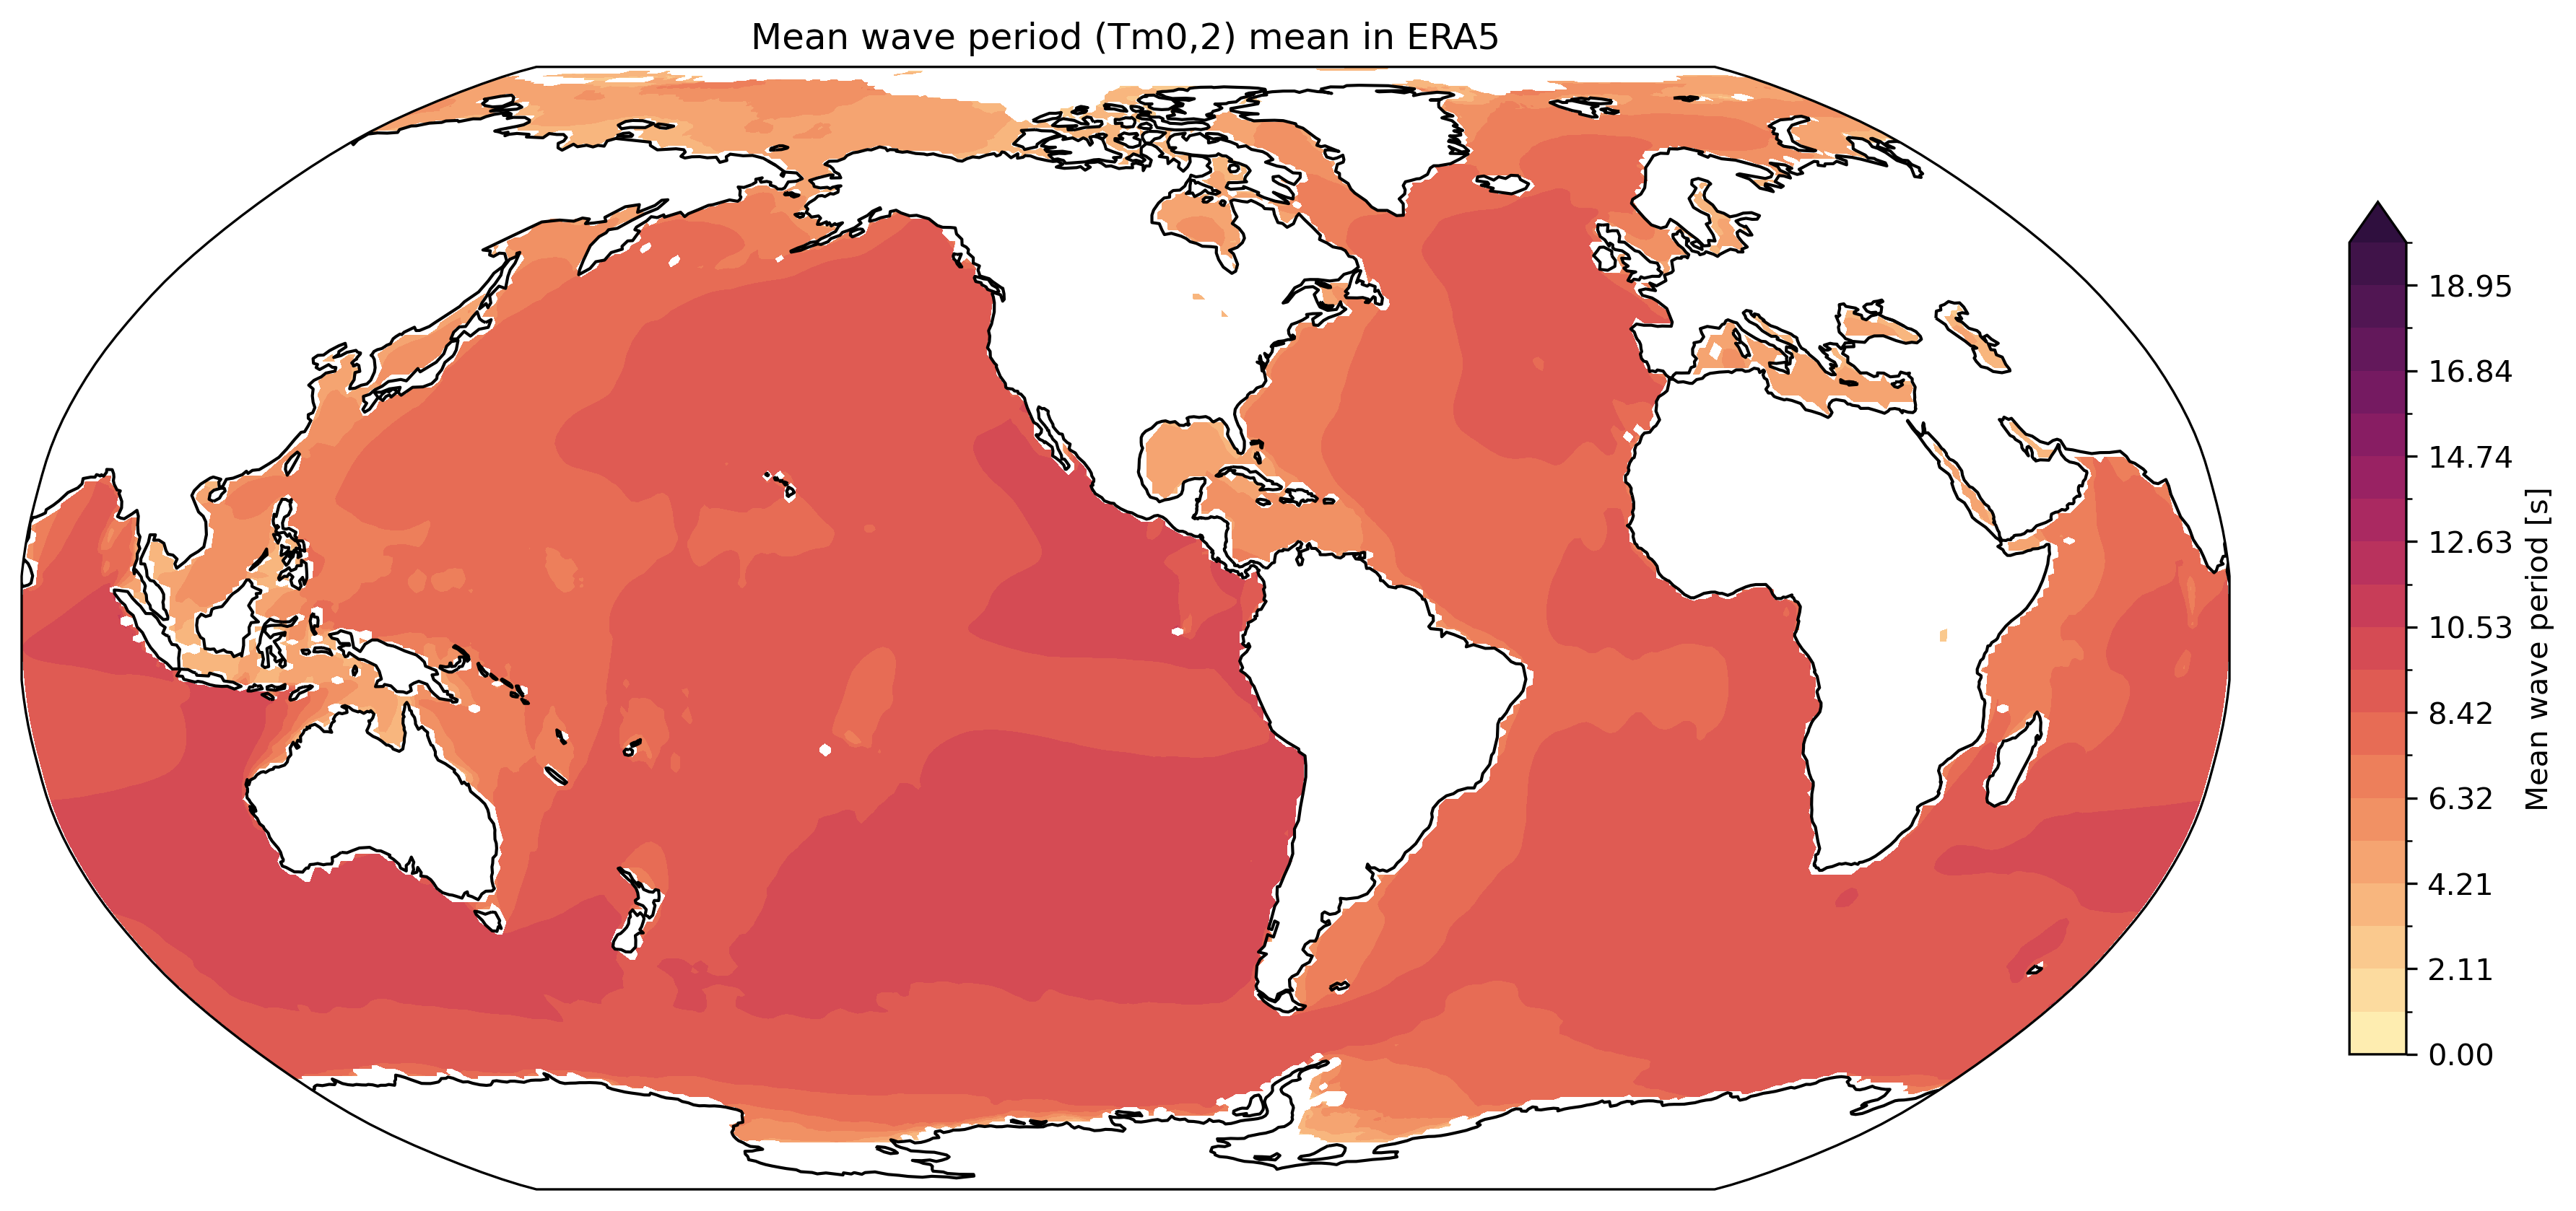

In [31]:
ax = plot(
    obs_on_model,
    levels=20,
    vmin=0,
    vmax=20,
    extend="max",
    cmap= cmocean.cm.matter,
    title=(
        f"{long_name} "
        f"mean in ERA5"
    ),
)

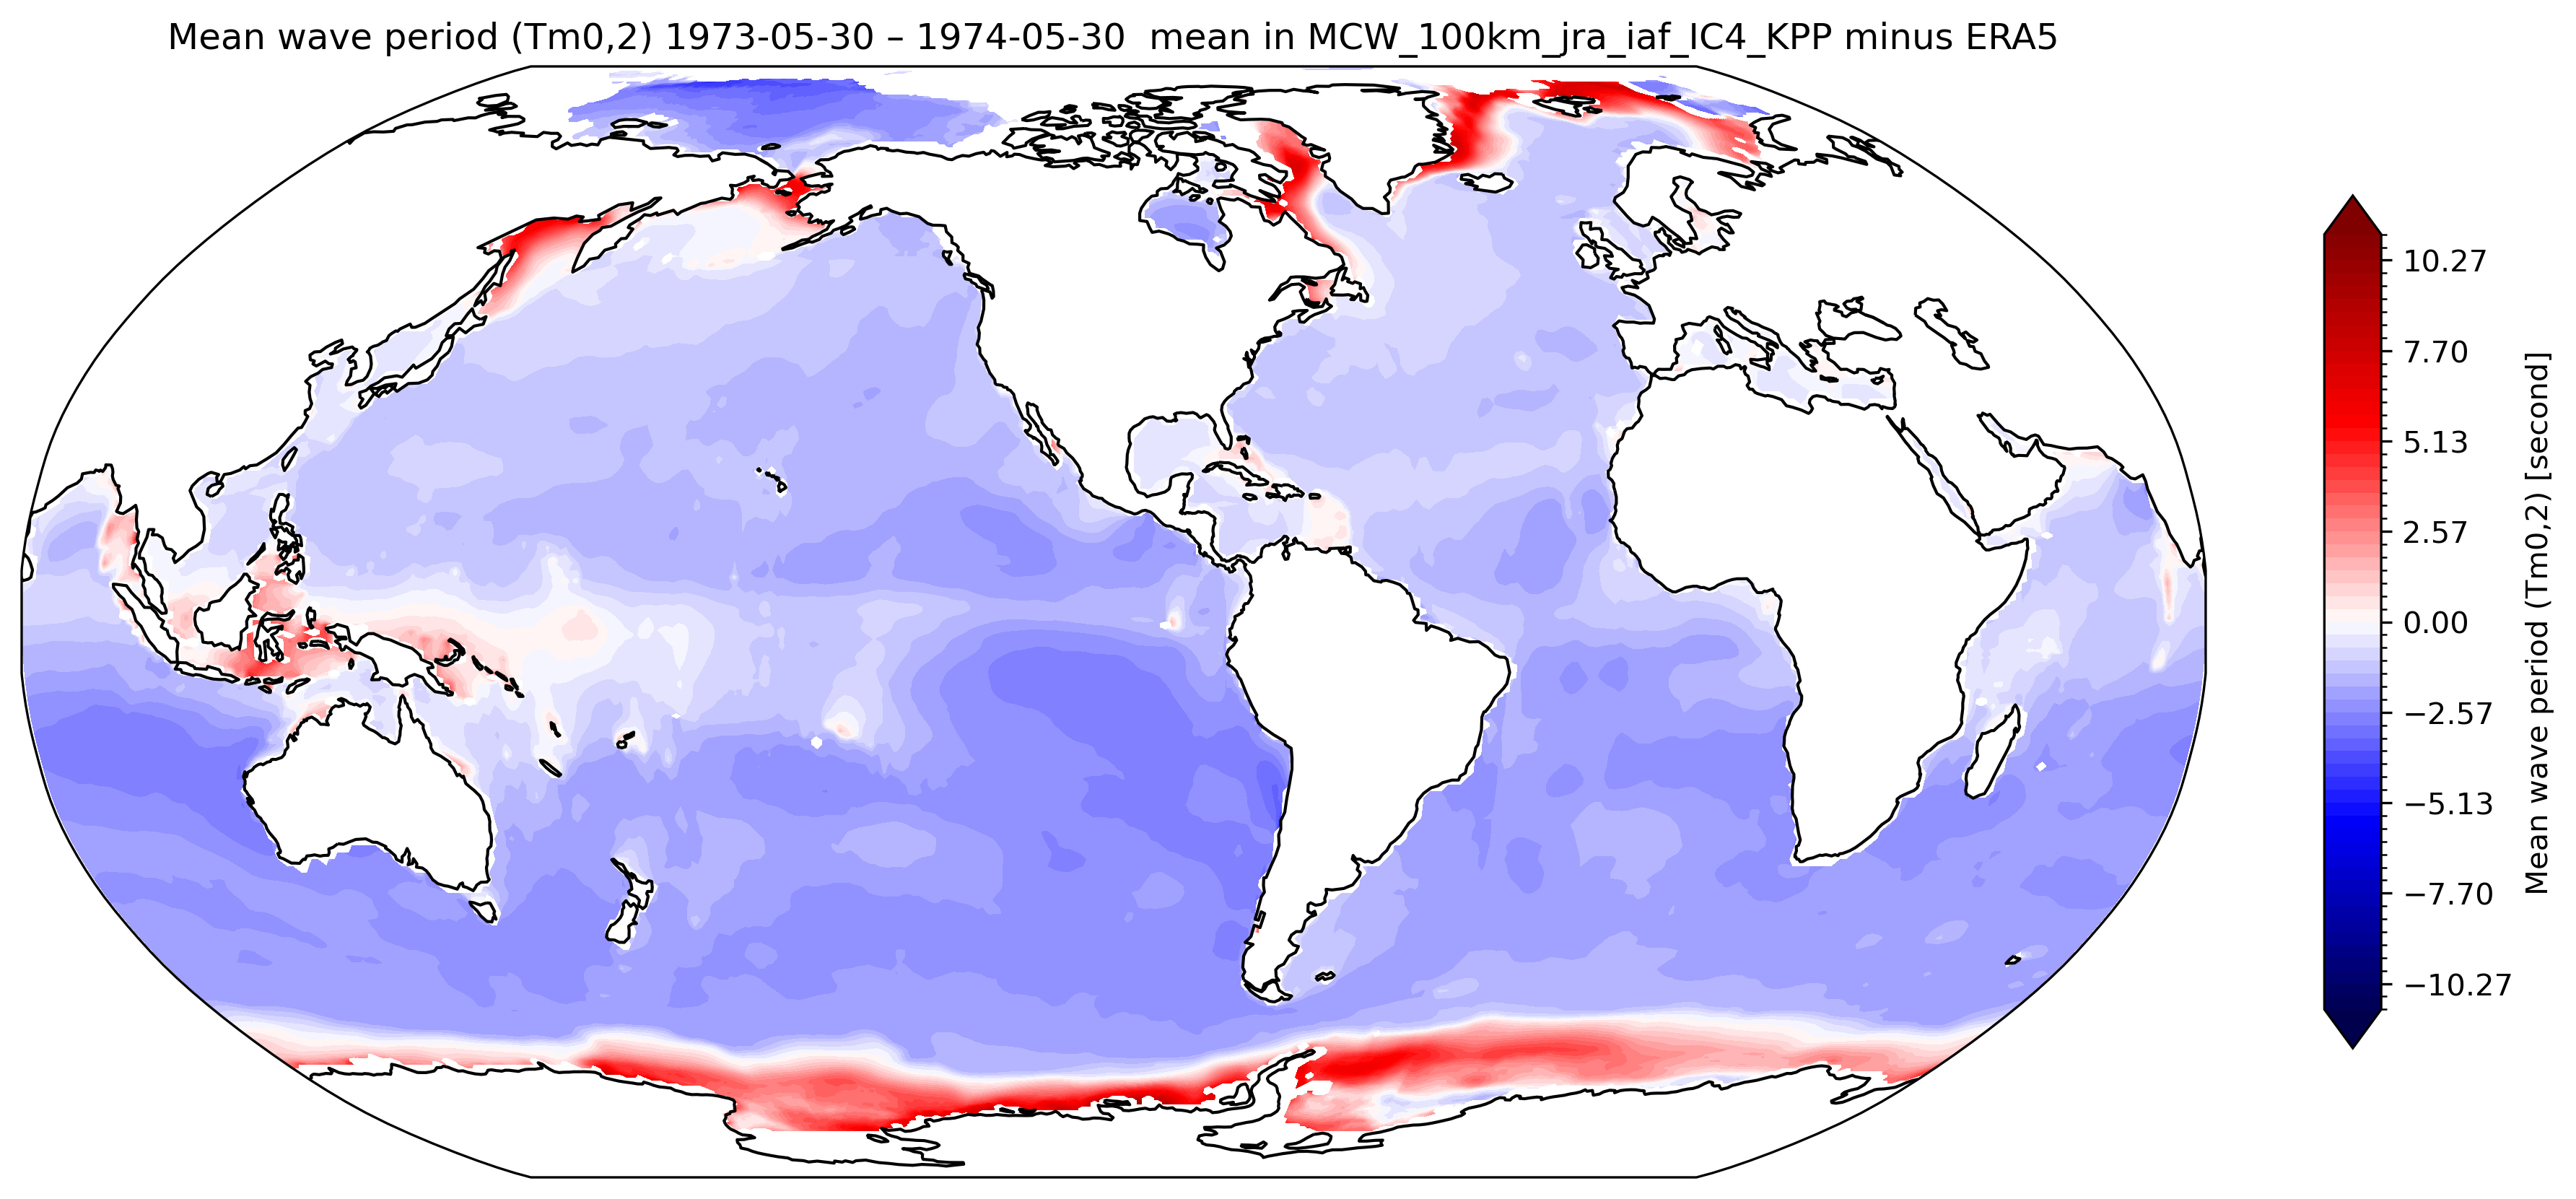

In [32]:
# 3) Plot the bias
long_name = model.attrs.get("long_name", "HS")

plot(
    bias,
    levels=61,
    vmin =-11,
    vmax=11,
    extend="both",
    cmap="seismic",
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f" mean in {exptname} minus ERA5"
    ),
)

In [33]:
# Mask invalid / near-zero obs to avoid blow-ups
eps = 0.05  # 5 cm threshold, adjust if needed
valid = obs_on_model > eps

del_hs_pct = xr.where(
    valid,
    100.0 * bias / obs_on_model,
    np.nan
)

del_hs_pct.name = "del_hs_pct"
del_hs_pct.attrs.update({
    "long_name": "Percentage bias in significant wave height",
    "units": "%",
    "description": "(model - obs) / obs * 100"
})

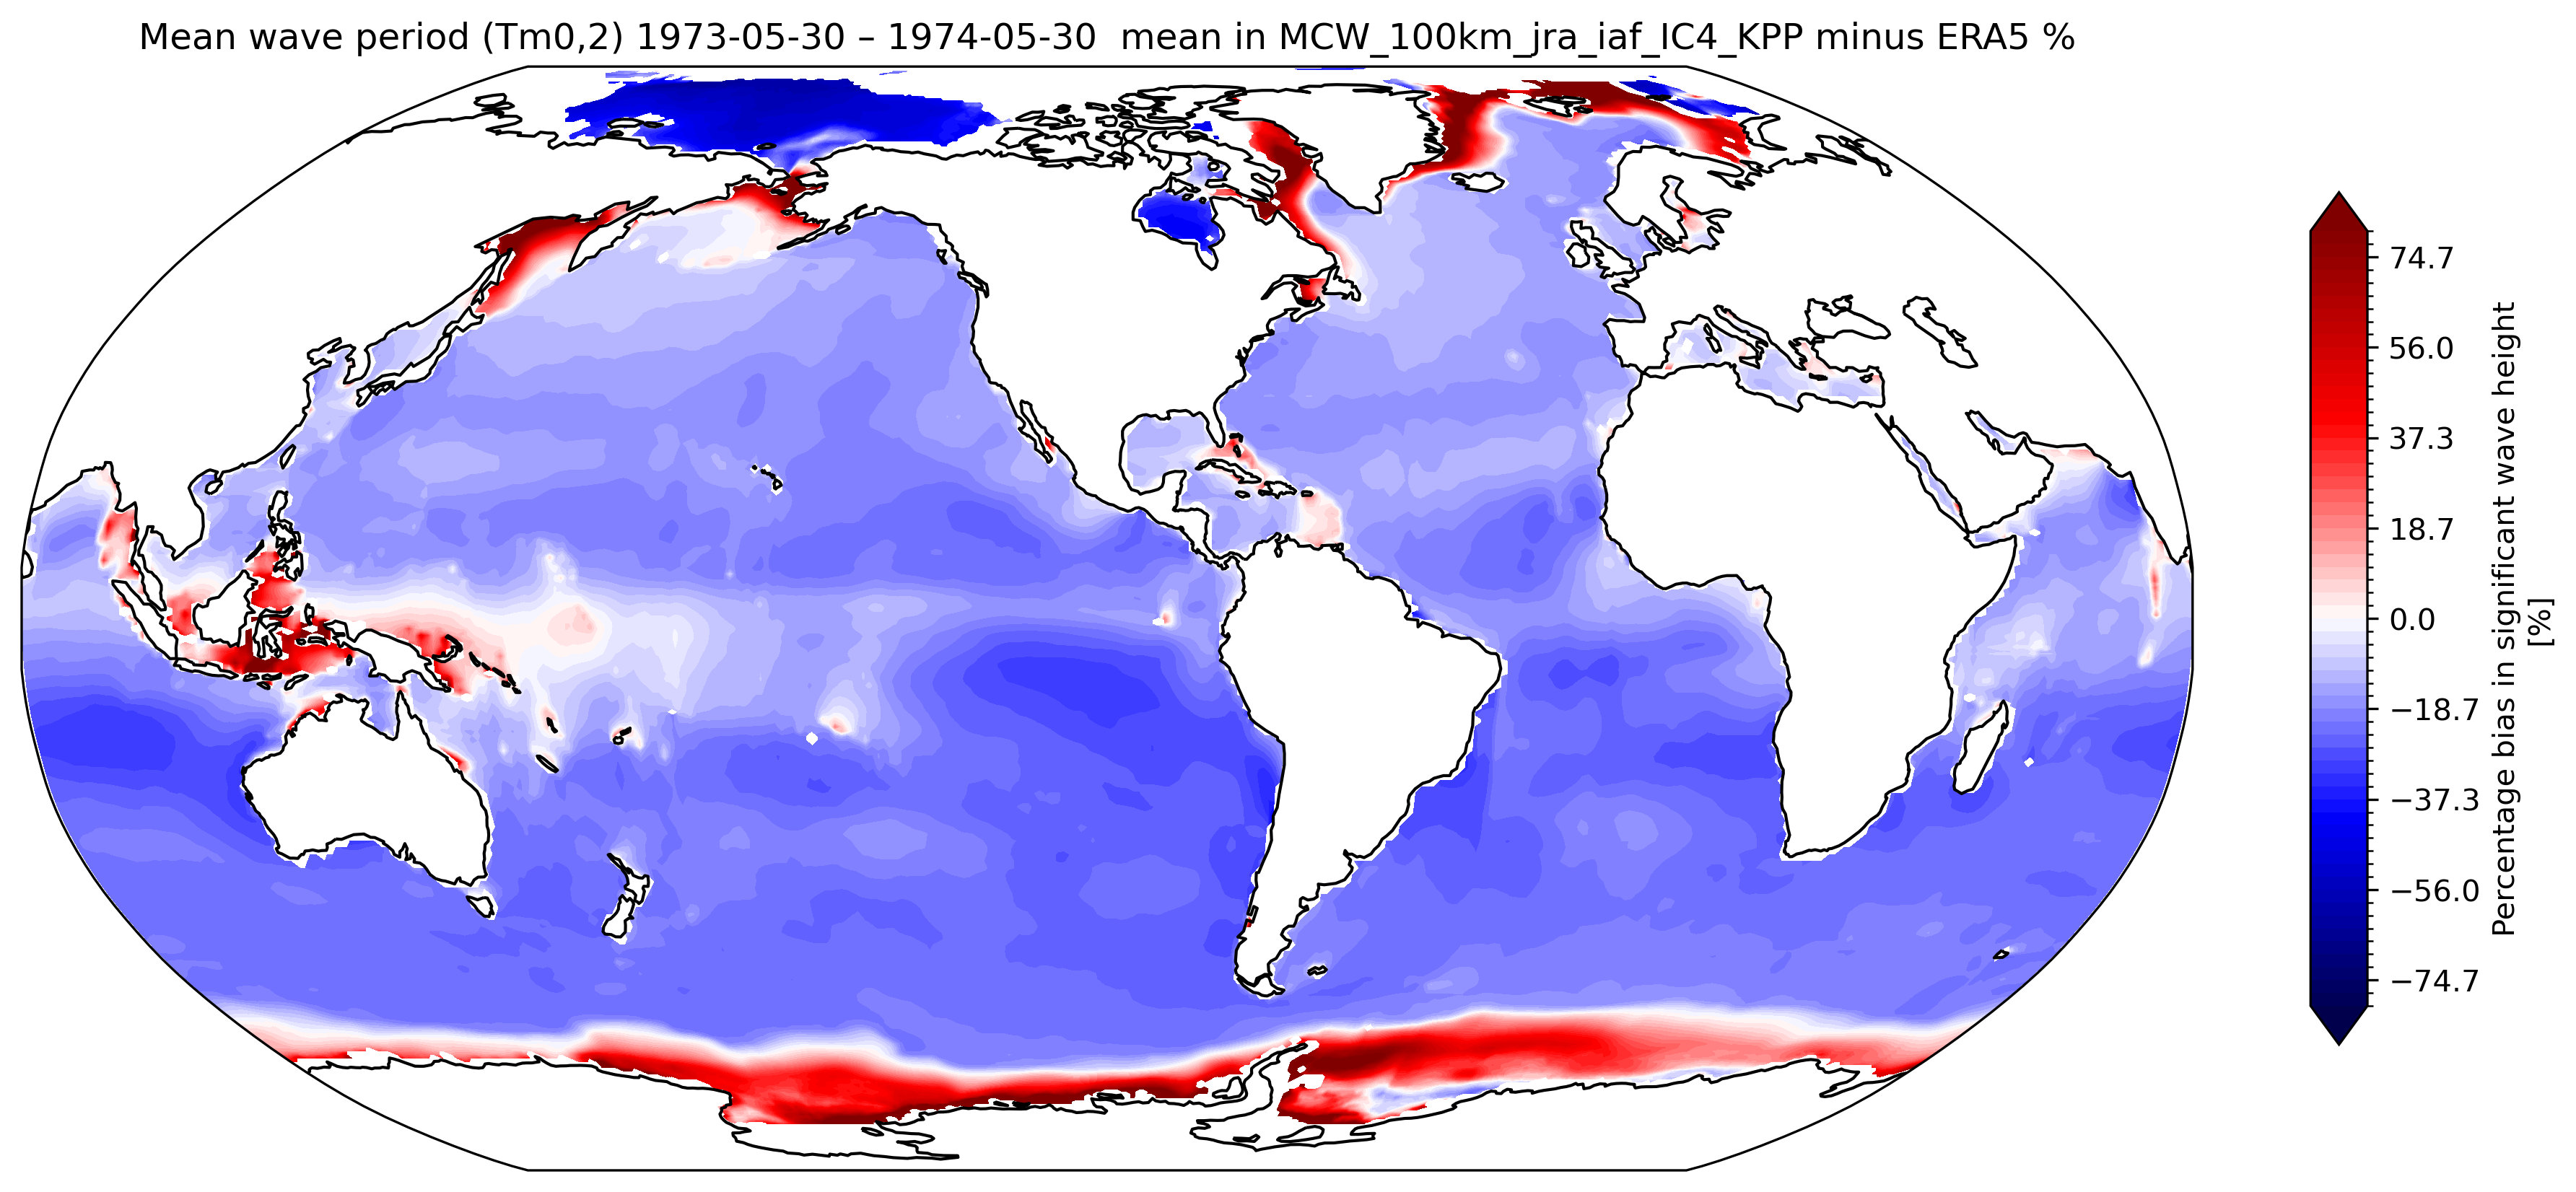

In [40]:
plot(
    del_hs_pct,
    levels=61,
    extend="both",
    cmap="seismic",
    vmin = -80,
    vmax = 80,
    title=(
        f"{long_name} "
        f"{datestart.strftime('%Y-%m-%d')} – {datestop.strftime('%Y-%m-%d')} "
        f" mean in {exptname} minus ERA5 %"
    ),
)

In [35]:
common_mask = np.isfinite(obs_on_model) & np.isfinite(model)
model_q = time_percentiles(model_window, mask=common_mask, name="tm", compute=False)

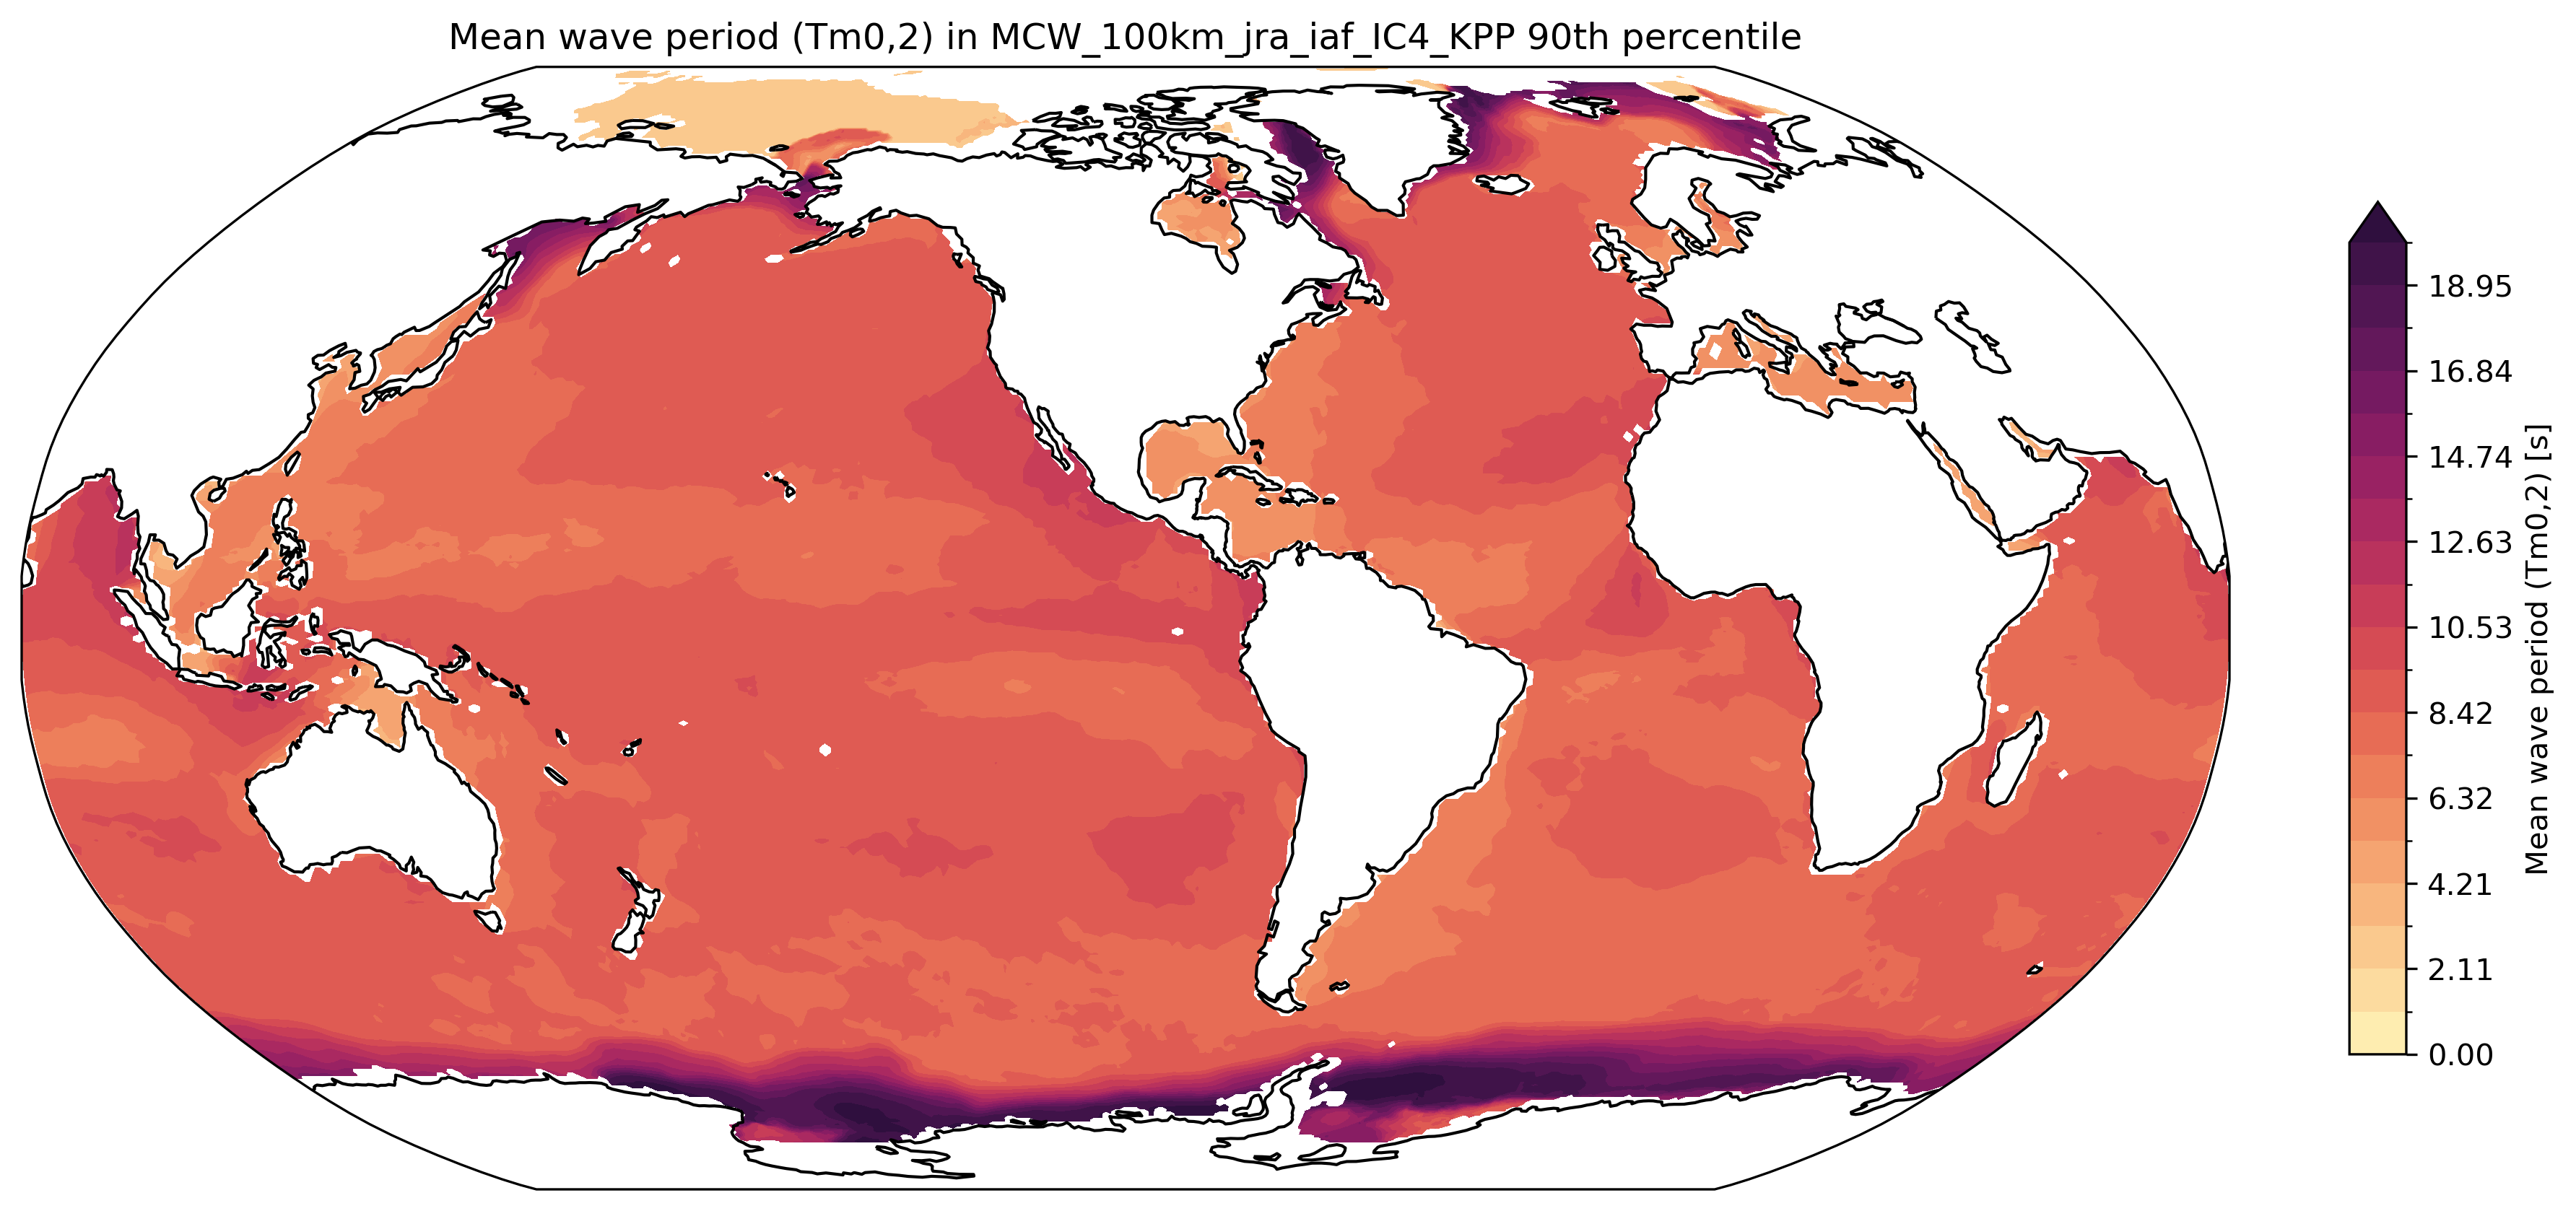

In [36]:
ax = plot(
    model_q.q90_tm,
    levels=20,
    vmin=0,
    vmax=20,
    extend="max",
    cmap= cmocean.cm.matter,
    title=(
        f"{long_name} in {exptname} "
        f"90th percentile"
    ),
)

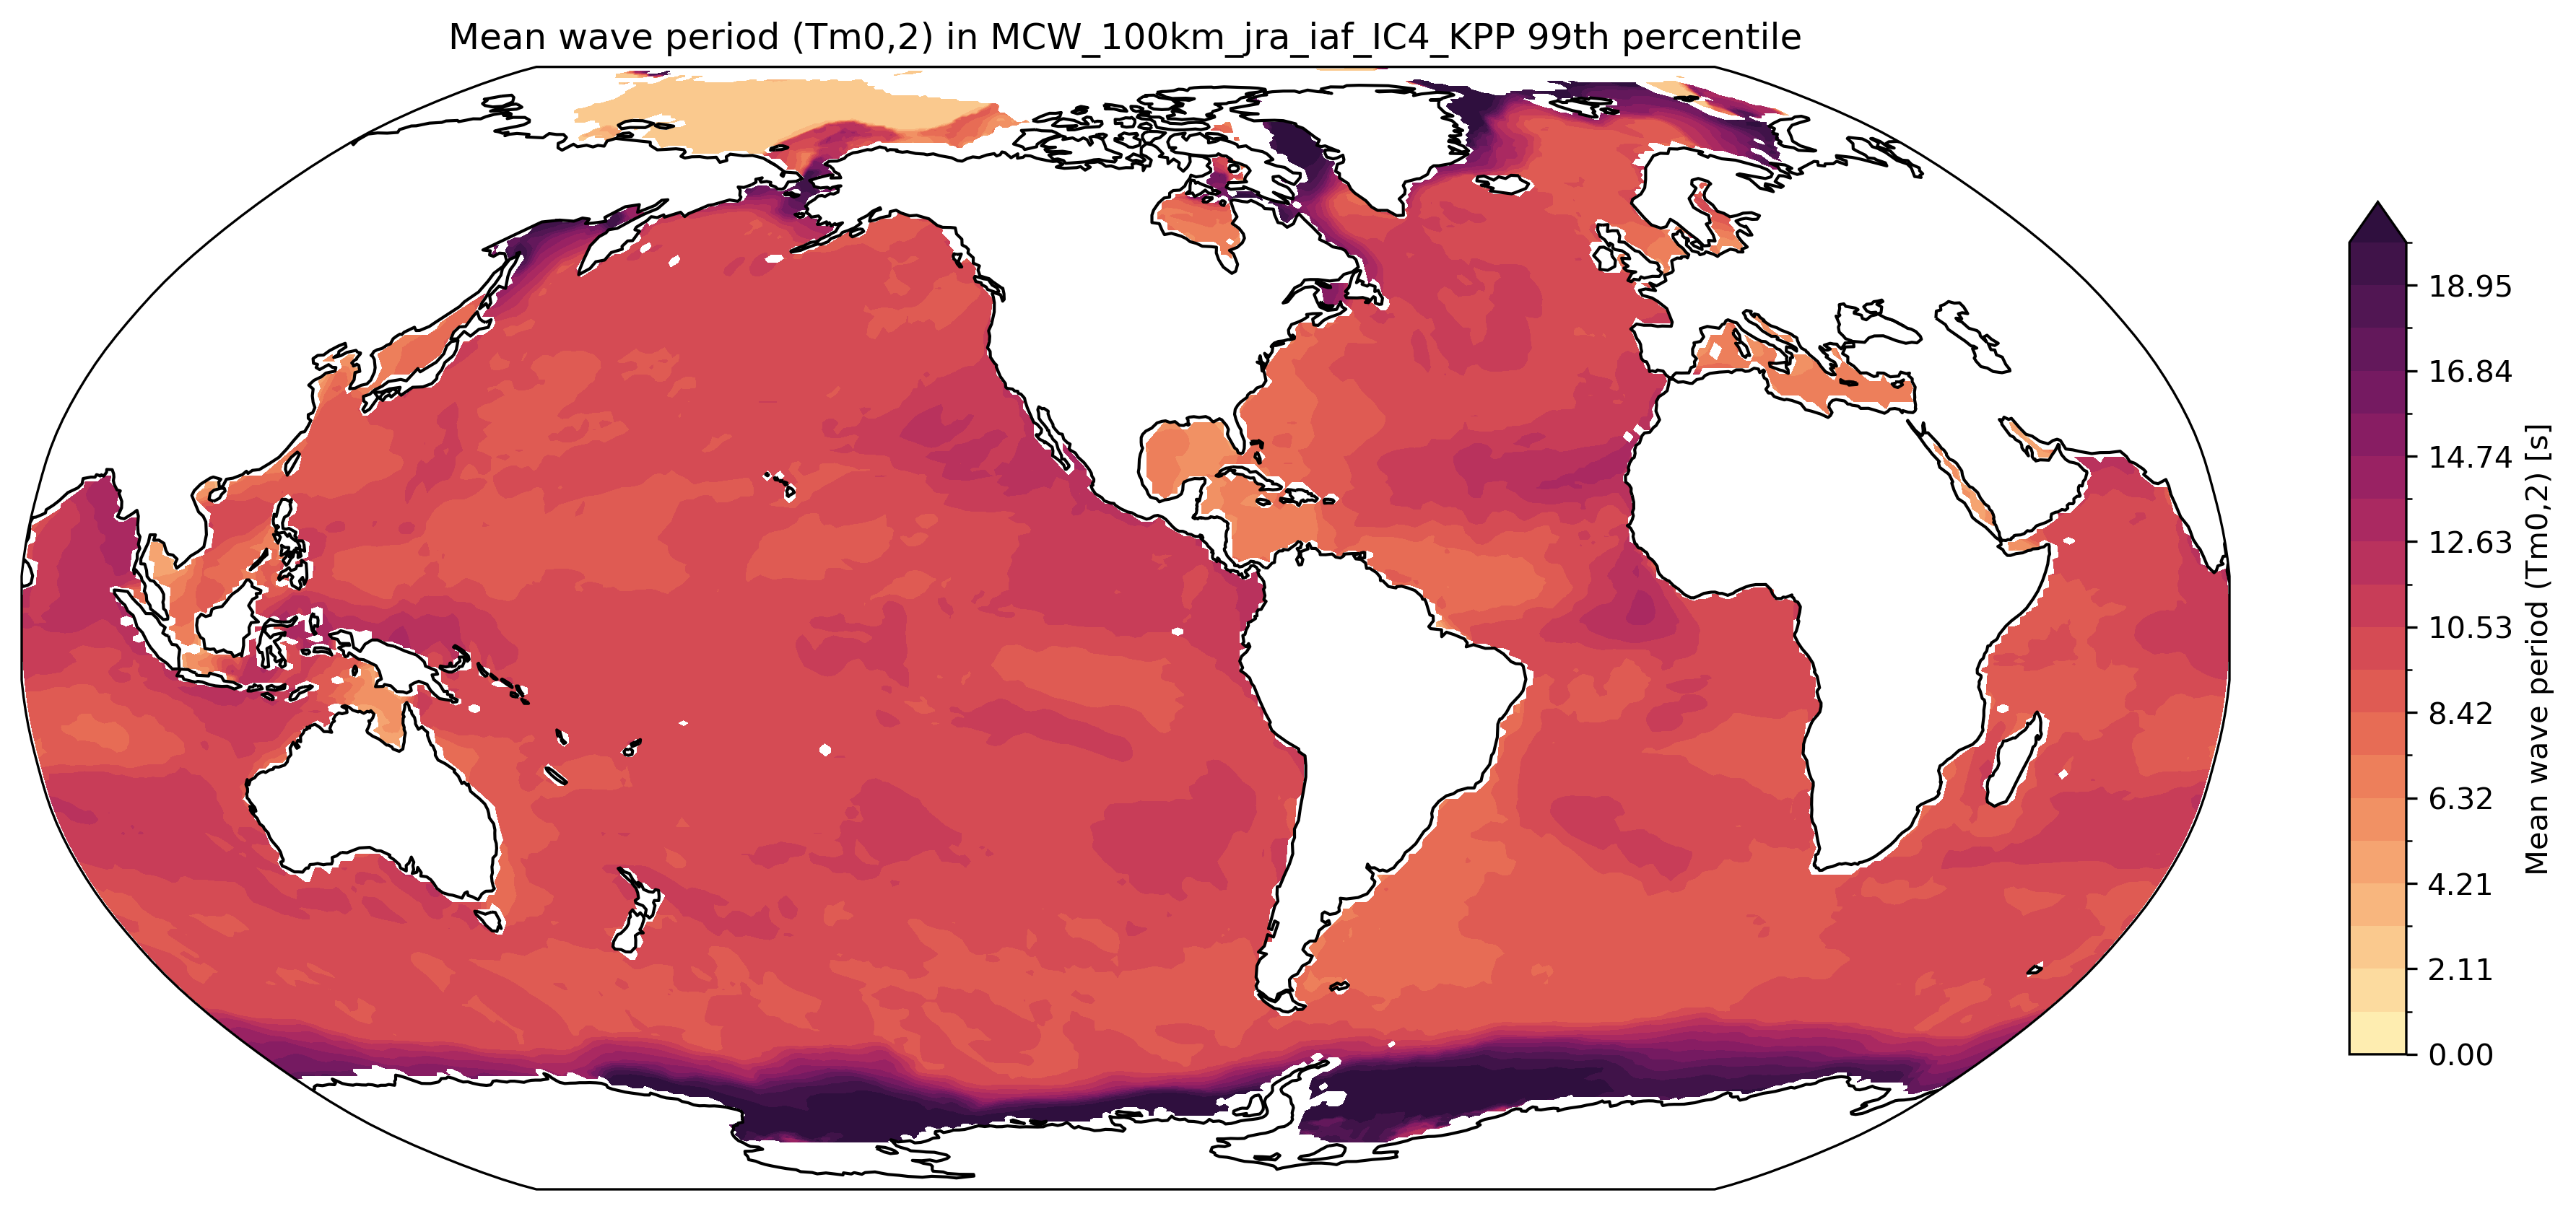

In [37]:
ax = plot(
    model_q.q99_tm,
    levels=20,
    vmin=0,
    vmax=20,
    extend="max",
    cmap= cmocean.cm.matter,
    title=(
        f"{long_name} in {exptname} "
        f"99th percentile"
    ),
)